#DS-5220: Supervised Machine Learning Final Project
#Charvi Madan
#NUID-002107664

# Importing the libraries

In [1]:
import torchvision
import torch
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import time
import pandas as pd
import torchvision.datasets as datasets
from IPython import display
import matplotlib.pyplot as plt
import torchvision.transforms

In [2]:
!pip install torchvision

# Defined batch size and loaded dataset to dataloader


In [3]:
batch_size = 32
transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_ds = DataLoader(datasets.CIFAR10("data", train=True, transform=transform, download=True), batch_size=batch_size)
test_ds = DataLoader(datasets.CIFAR10("data", train=False, transform=transform, download=True), batch_size=batch_size)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


#Defining the Convolution Neural Network Model 


In [4]:
class CNNModel(nn.Module):
    
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# initialsed the model 

In [5]:
model = CNNModel(num_classes=10)

Choosing the ADAM optimizer and Cross entropy loss function

In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model.to(device)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=2048, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_

Creating the training function and time stamps for each epochs

In [8]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    dictCNN = {} # Collects per-epoch loss and acc like Keras' fit().
    dictCNN['loss'] = []
    dictCNN['val_loss'] = []
    dictCNN['acc'] = []
    dictCNN['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        if epoch == 1 or epoch % 2 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        dictCNN['loss'].append(train_loss)
        dictCNN['val_loss'].append(val_loss)
        dictCNN['acc'].append(train_acc)
        dictCNN['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return dictCNN

In [9]:
clf = train(model, optimizer,torch.nn.CrossEntropyLoss(), train_ds,test_ds, epochs=20, device=device)

train() called: model=CNNModel, opt=Adam(lr=0.001000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  1.47, train acc:  0.46, val loss:  1.15, val acc:  0.59
Epoch   2/ 20, train loss:  1.11, train acc:  0.61, val loss:  0.92, val acc:  0.68
Epoch   4/ 20, train loss:  0.87, train acc:  0.70, val loss:  0.80, val acc:  0.73
Epoch   6/ 20, train loss:  0.77, train acc:  0.73, val loss:  0.73, val acc:  0.75
Epoch   8/ 20, train loss:  0.70, train acc:  0.76, val loss:  0.66, val acc:  0.77
Epoch  10/ 20, train loss:  0.64, train acc:  0.78, val loss:  0.71, val acc:  0.76
Epoch  12/ 20, train loss:  0.61, train acc:  0.79, val loss:  0.73, val acc:  0.75
Epoch  14/ 20, train loss:  0.58, train acc:  0.80, val loss:  0.64, val acc:  0.78
Epoch  16/ 20, train loss:  0.55, train acc:  0.81, val loss:  0.64, val acc:  0.78
Epoch  18/ 20, train loss:  0.53, train acc:  0.82, val loss:  0.65, val acc:  0.78
Epoch  20/ 20, train loss:  0.50, train acc:  0.83, val loss:  0.64, val acc:  0.

#Visualizing the model 

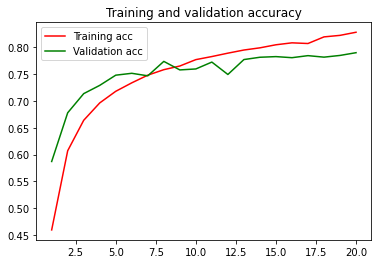

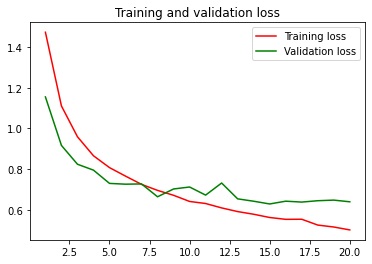

In [10]:
import matplotlib.pyplot as plt

acc = clf['acc']
val_acc = clf['val_acc']
loss = clf['loss']
val_loss = clf['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#defining the DNN model

In [11]:

class DNNModel(nn.Module):
    
    def __init__(self, num_classes):
        super(DNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(64*64*3,4096),
            nn.ReLU(),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Linear(4096,2048),
            nn.ReLU(),
            nn.Linear(2048,num_classes),
            nn.ReLU()
        )

    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.features(x)
        return x   
        

#Initializing the model 



In [12]:
model1 = DNNModel(num_classes = 10)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model1.to(device)

DNNModel(
  (features): Sequential(
    (0): Linear(in_features=12288, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=2048, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=10, bias=True)
    (7): ReLU()
  )
)

choosing the stochastic gradient descent optimizer and Cross entropy loss function 


In [13]:
learningRate = 0.001
optimizer = torch.optim.SGD(model1.parameters(), lr=learningRate)

In [14]:
clf1 = train(model1, optimizer,torch.nn.CrossEntropyLoss(), train_ds,test_ds, epochs=20, device=device)

train() called: model=DNNModel, opt=SGD(lr=0.001000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  2.15, train acc:  0.25, val loss:  2.01, val acc:  0.30
Epoch   2/ 20, train loss:  1.91, train acc:  0.34, val loss:  1.82, val acc:  0.36
Epoch   4/ 20, train loss:  1.67, train acc:  0.41, val loss:  1.64, val acc:  0.43
Epoch   6/ 20, train loss:  1.56, train acc:  0.46, val loss:  1.54, val acc:  0.46
Epoch   8/ 20, train loss:  1.47, train acc:  0.49, val loss:  1.48, val acc:  0.48
Epoch  10/ 20, train loss:  1.40, train acc:  0.51, val loss:  1.43, val acc:  0.50
Epoch  12/ 20, train loss:  1.33, train acc:  0.54, val loss:  1.39, val acc:  0.52
Epoch  14/ 20, train loss:  1.27, train acc:  0.56, val loss:  1.35, val acc:  0.53
Epoch  16/ 20, train loss:  1.21, train acc:  0.58, val loss:  1.33, val acc:  0.54
Epoch  18/ 20, train loss:  1.15, train acc:  0.61, val loss:  1.31, val acc:  0.54
Epoch  20/ 20, train loss:  1.09, train acc:  0.63, val loss:  1.29, val acc:  0.5

#Visualizing the results

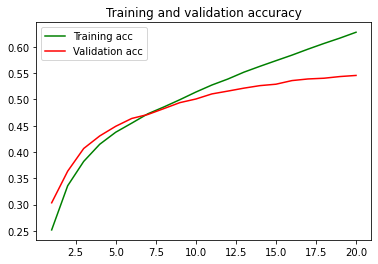

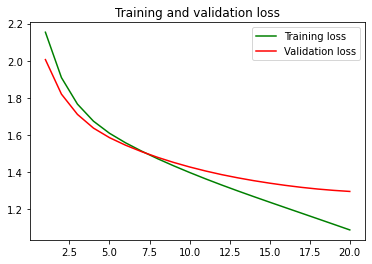

In [15]:
acc = clf1['acc']
val_acc = clf1['val_acc']
loss = clf1['loss']
val_loss = clf1['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#summary of both models 


In [16]:
from torchsummary import summary
summary(model, (3, 64, 64))
summary(model1, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
         MaxPool2d-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]         295,168
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
AdaptiveAvgPool2d-13            [-1, 256, 4, 4]               0
          Dropout-14                 [-